In [1]:
from ananke.configurations.collection import HDF5StorageConfiguration
from ananke.models.collection import Collection
from ananke.configurations.collection import RedistributionConfiguration
from ananke.configurations.events import EventRedistributionMode
from ananke.configurations.collection import MergeConfiguration
import multiprocessing
lock = multiprocessing.Lock()

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot(hits):
    """
    Generate and display a histogram plot of 'time' for different 'type' values 
    within a specific 'record_id' in the given DataFrame.
    """
    info={
        0:'Realistic Tracks',
        1:'Cascades',
        2:'Starting Track',
        20:'Electrical noise',
        21:'biolumi noise',
    }

    
    # Select the first unique record_id
    record = hits['record_id'].unique()[0]
    
    # Get all unique types
    types = hits['type'].unique()
    
    # Filter hits for the selected record_id
    hit = hits[hits['record_id'] == record]
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    interval = np.arange(hit['time'].min(), hit['time'].max(), 100)

    # Iterate through each unique type and plot its histogram
    for t in types:
        y, x = np.histogram(hit[hit['type'] == t]['time'], bins=interval)
        x = (x[:-1] + x[1:]) / 2  # Convert bin edges to bin centers
        ax.plot(x, y+1, label=f'{info[t]}')
        
    y, x = np.histogram(hit['time'], bins=interval)
    x = (x[:-1] + x[1:]) / 2  # Convert bin edges to bin centers
    ax.plot(x, y+1, label=f'Type : All')

    # Labeling and legend
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Hit histogram for Record ID {record}")
    ax.legend()

    # Show the plot each time the function is called
    plt.yscale('log')
    plt.show()

# Example usage:
#plot(hits)  # This will display the plot each time the function is called


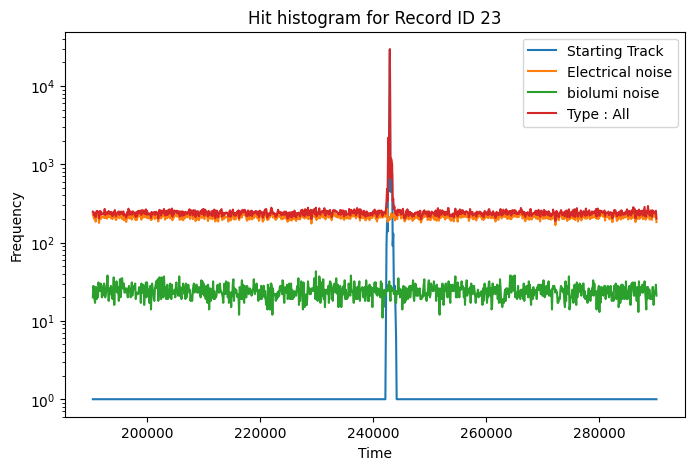

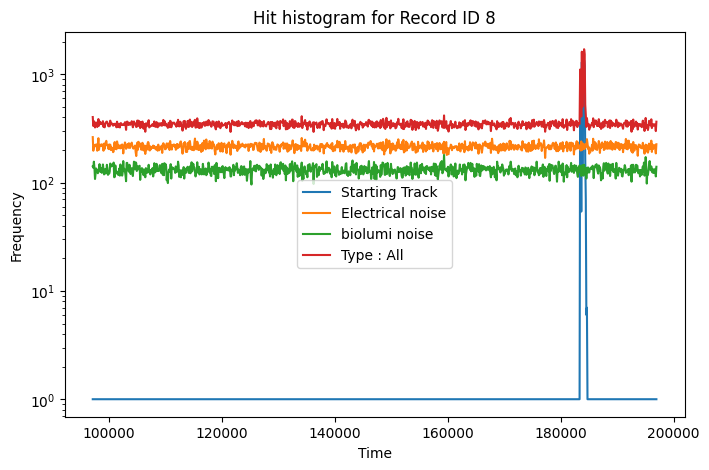

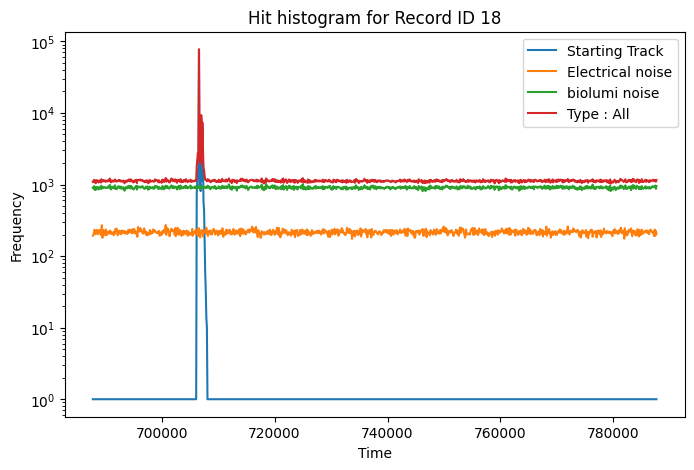

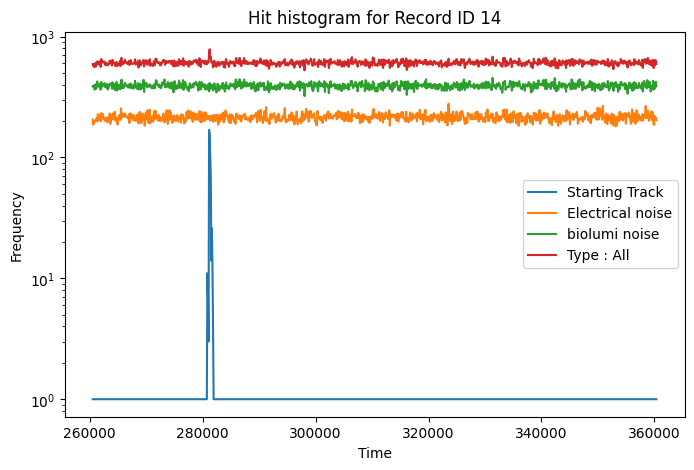

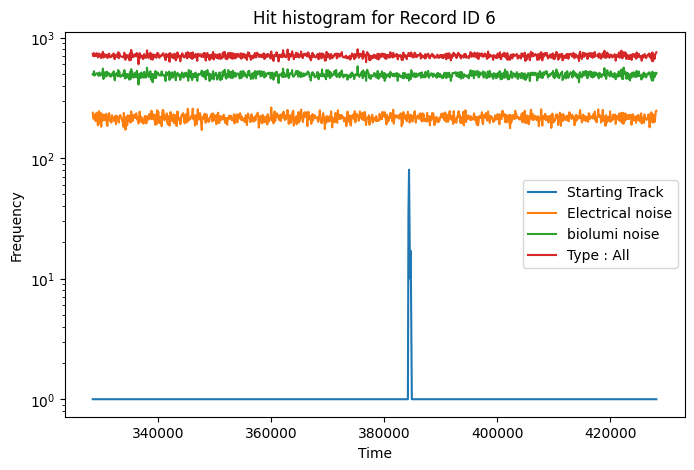

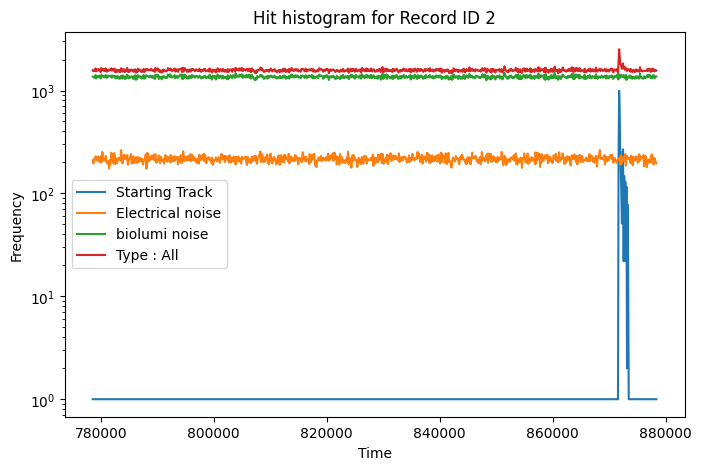

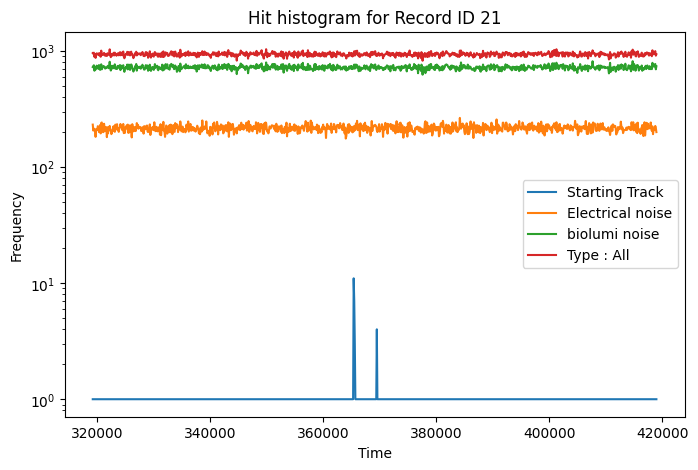

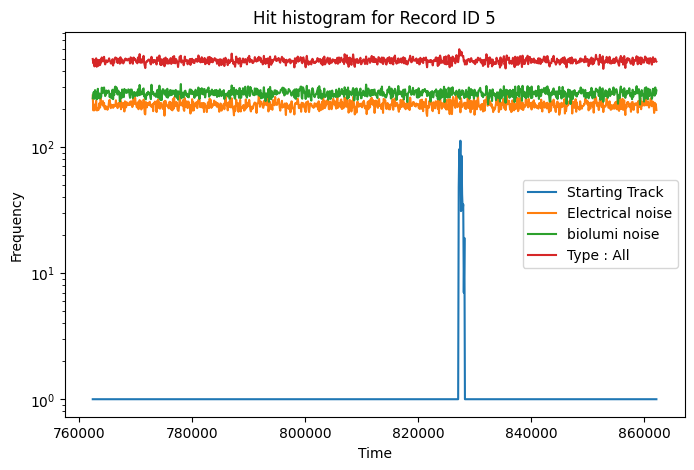

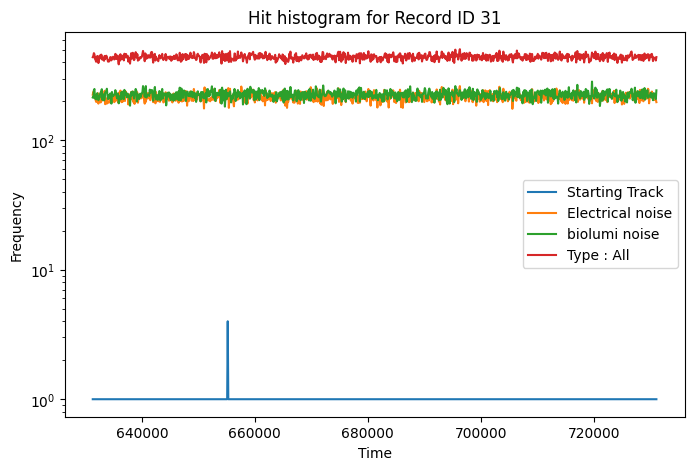

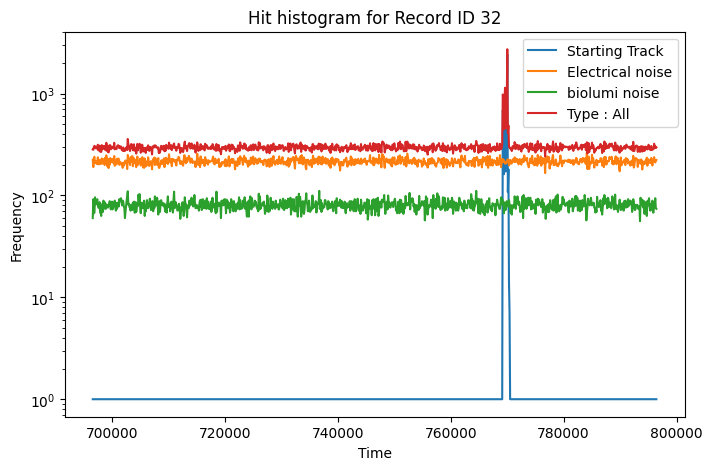

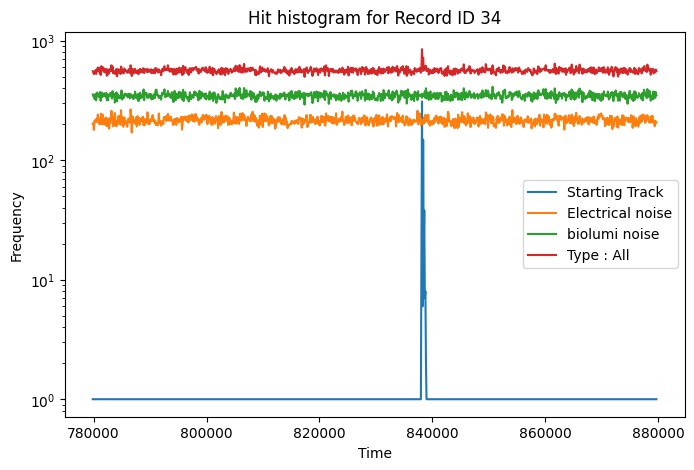

In [9]:
path= 'Data/RT.h5'
c=HDF5StorageConfiguration(data_path=path)
c=Collection(c)
with c:
    hits=c.storage.get_hits().df
for r in hits['record_id'].unique():
    plot(hits[hits['record_id']==r])

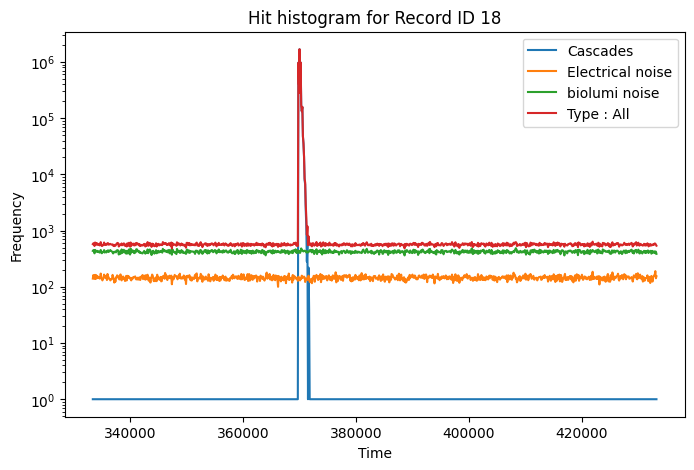

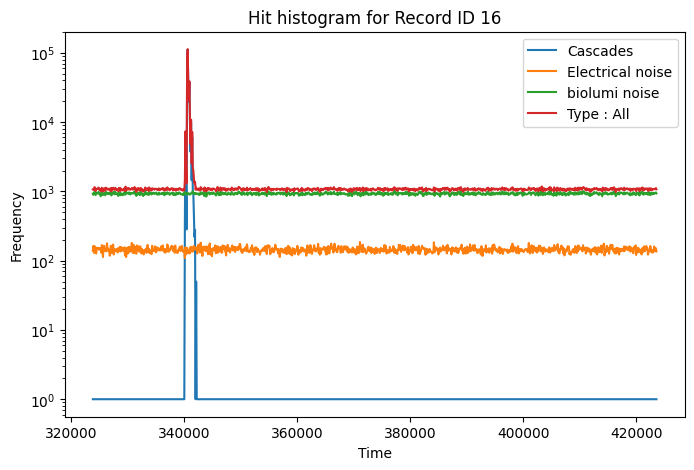

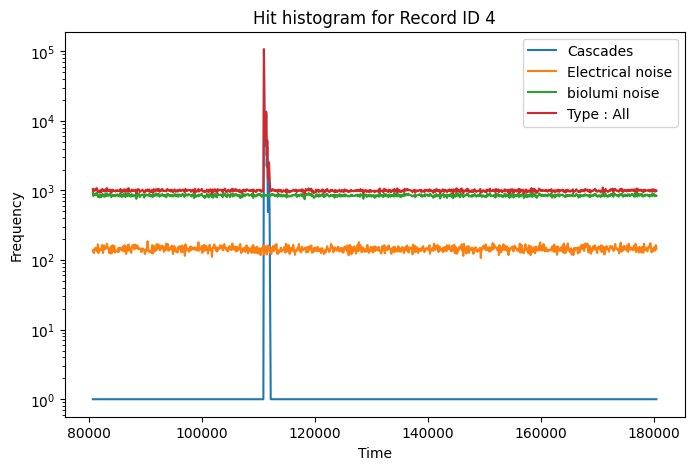

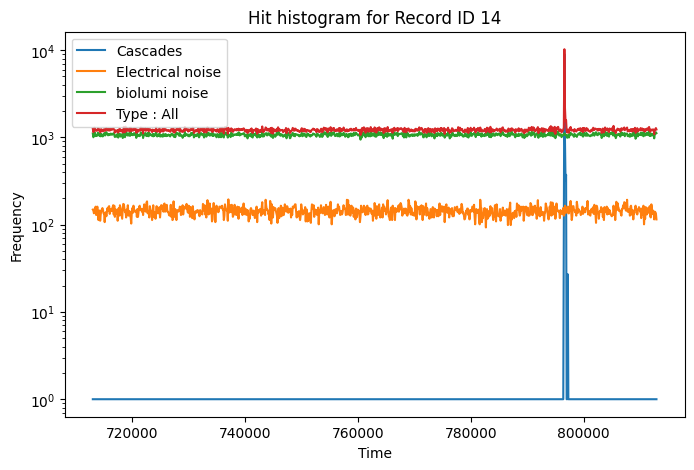

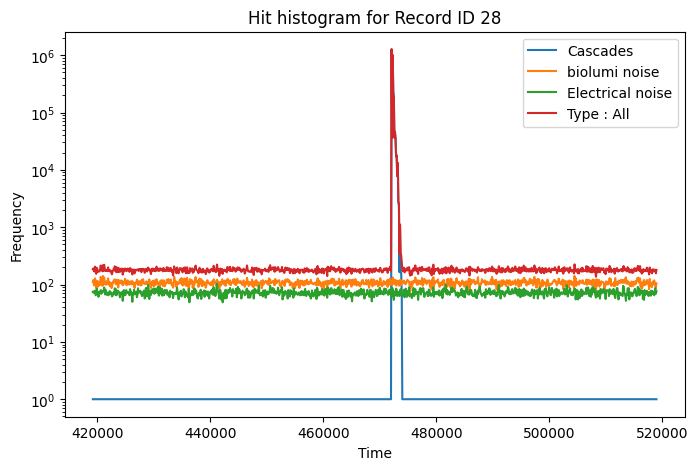

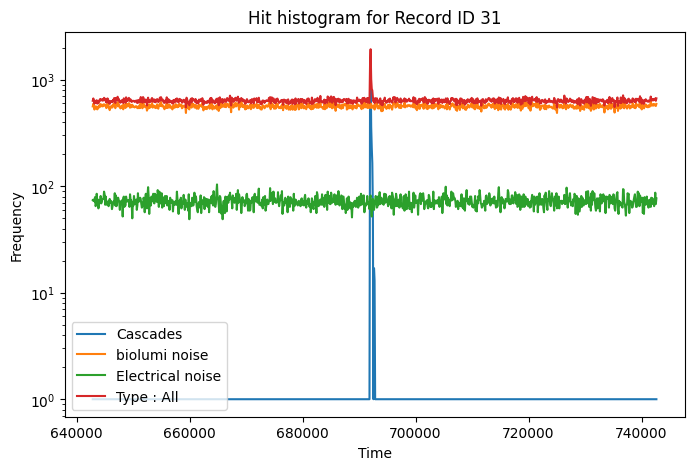

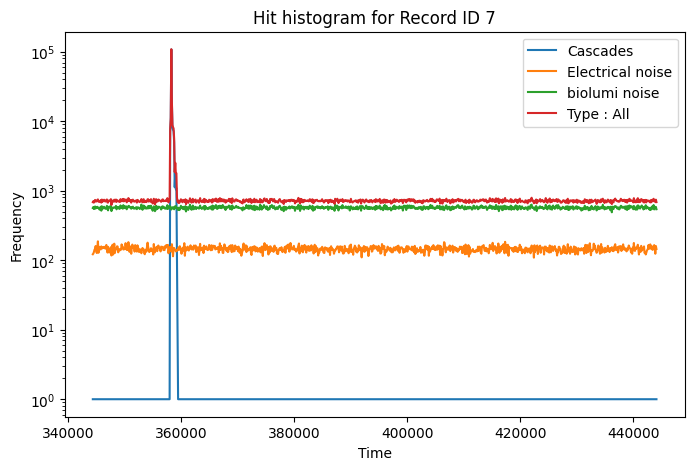

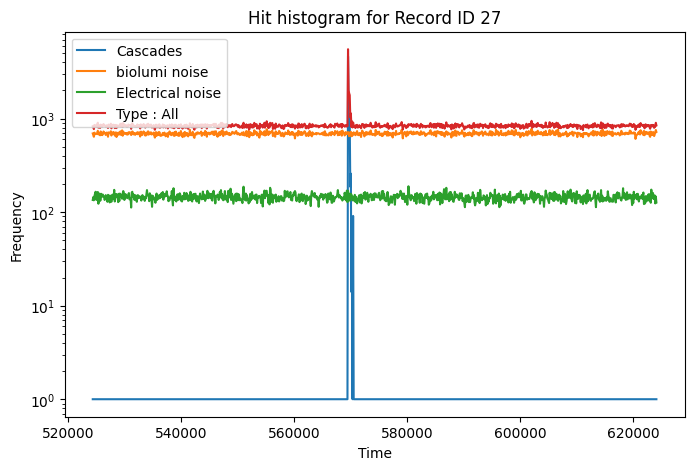

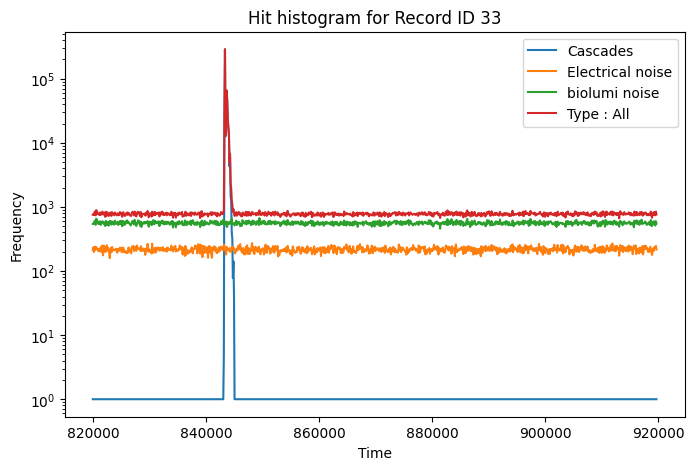

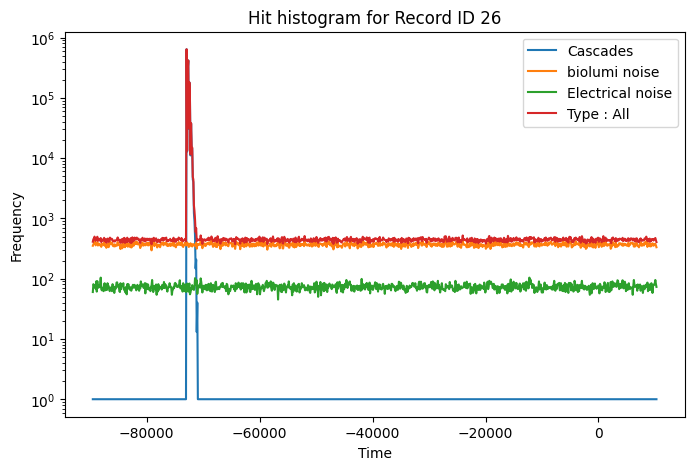

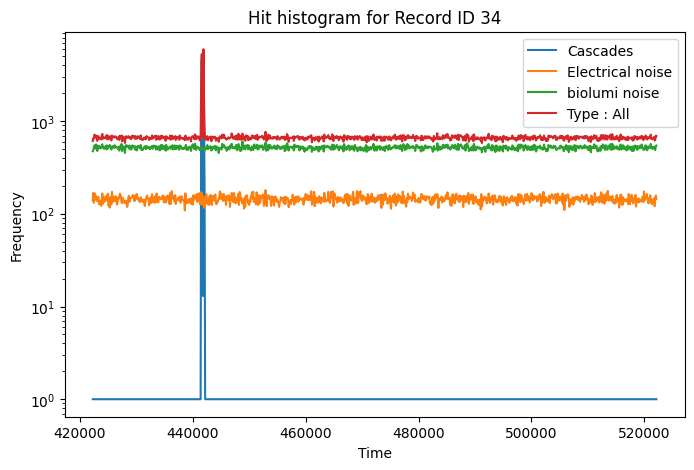

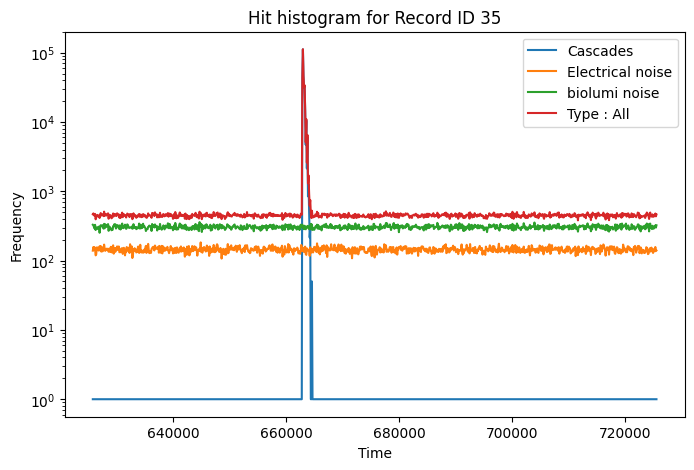

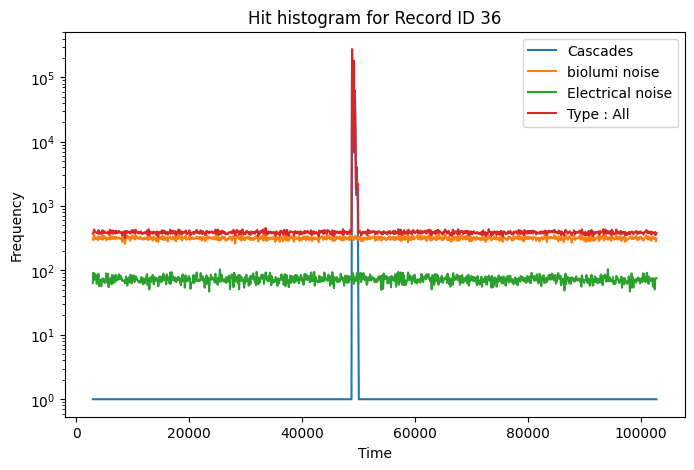

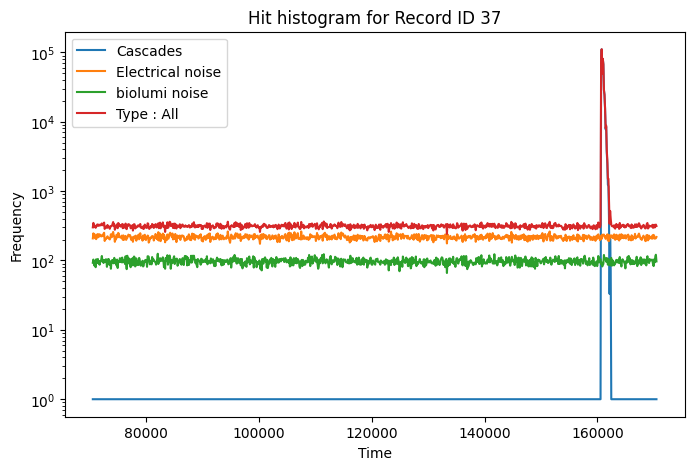

In [10]:
path= 'Data/RC.h5'
c=HDF5StorageConfiguration(data_path=path)
c=Collection(c)
with c:
    hits=c.storage.get_hits().df
for r in hits['record_id'].unique():
    plot(hits[hits['record_id']==r])

In [1]:
path='/viper/ptmp1/arego/LargeTracks/0.h5'

In [2]:
import pandas as pd

In [15]:
hits=pd.read_hdf(path,key='hits')
records=pd.read_hdf(path,key='records')
record_Counts = hits['record_id'].value_Counts().reset_index()
record_Counts.columns = ['record_id', 'count']  # Rename columns for clarity
# Assuming df contains an 'energy' column along with 'record_id'
merged_df = records[['record_id','energy']].merge(record_Counts, on='record_id', how='inner')
merged_df[['energy','count']].to_numpy()

Final Merged Shape: (499, 2)


In [35]:
import os
import pandas as pd
import numpy as np
import multiprocessing

def process_file(file_path):
    """Processes a single HDF5 file using HDFStore and returns an array of (energy, count) pairs."""
    try:
        with pd.HDFStore(file_path, mode='r') as store:
            hits = store["hits"]
            records = store["records"]

            record_Counts = hits["record_id"].value_Counts().reset_index()
            record_Counts.columns = ["record_id", "count"]

            merged_df = records[["record_id", "energy"]].merge(record_Counts, on="record_id", how="inner")

            return merged_df[["energy", "count"]].to_numpy()
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.empty((0, 2))  # Return empty array on failure

def process_directory(directory, num_workers=8):
    """Processes all .h5 files in a directory using multiprocessing and returns a merged numpy array."""
    h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".h5")]
    h5_files=h5_files[:100]
    with multiprocessing.Pool(processes=min(num_workers, len(h5_files))) as pool:
        results = pool.map(process_file, h5_files)

    return np.vstack(results) if results else np.empty((0, 2))

# Example usage
directory = "/viper/ptmp1/arego/LargeTracks/"
merged_array = process_directory(directory, num_workers=8)

print("Final Merged Shape:", merged_array.shape)  # Should be (N, 2), where N is the total rows across files


Final Merged Shape: (2000, 2)


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_scatter_density  # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# Define a new color map (for example, `inferno` or `plasma`)
cmap = plt.cm.inferno  # Feel free to change to `inferno`, `cividis`, etc.

def plot_energy_hits(Hit_Energy):
    """
    Loads energy and hit data from a .npy file and generates a scatter density plot.

    Parameters:
        Hit_Energy (numpy.ndarray): Array containing energy and hit data.

    Returns:
        None (displays the plot).
    """

    # Extract energy and hits
    energy = Hit_Energy[:, 0]
    hits = Hit_Energy[:, 1]

    # Filter out invalid energy values
    valid_indices = energy > 0
    x = np.log10(hits[valid_indices])  # Avoid log(0) issues
    y = np.log10(energy[valid_indices])

    # Create and show plot
    fig = plt.figure(figsize=(10, 6))  # Aspect ratio of 16:9
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=cmap)
    fig.colorbar(density, label='Event Density')

    # Plot aesthetics
    ax.set_xlabel("Log10(Hits)", fontsize=12)
    ax.set_ylabel("Log10(Energy)", fontsize=12)
    ax.set_title("Scatter Density Plot of Energy vs Hits", fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_energy_hits(np.load('your_data.npy'))


In [63]:
Track.shape[0]-RDT.shape[0]

14290

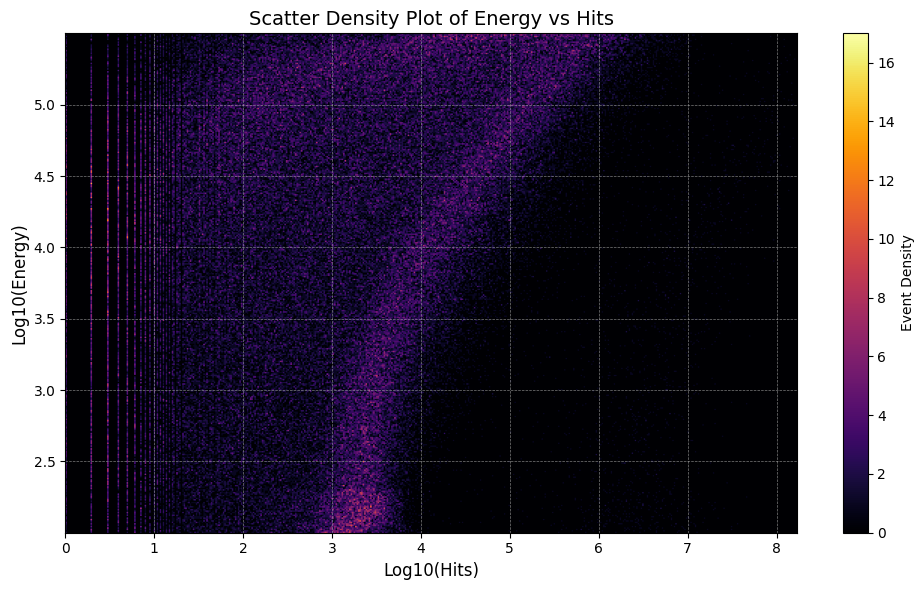

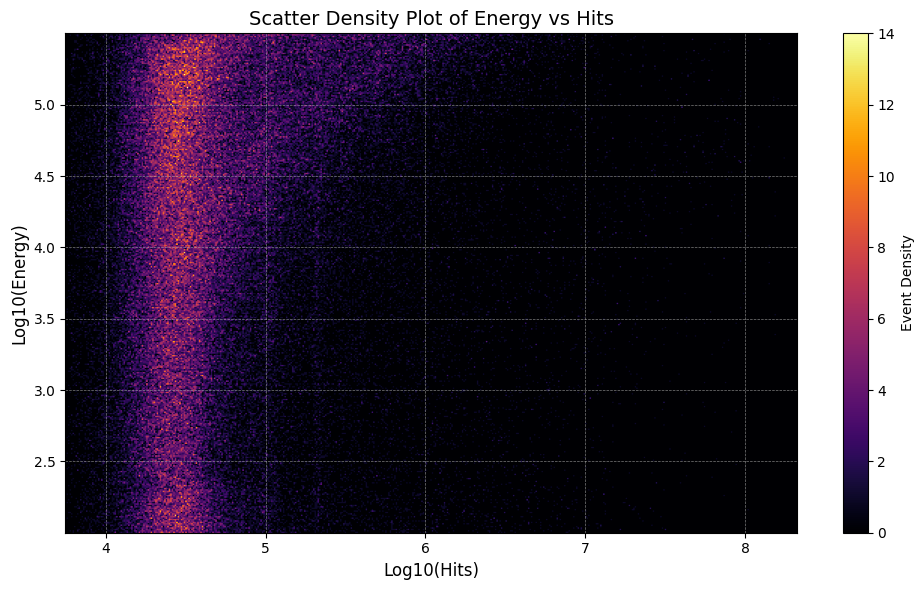

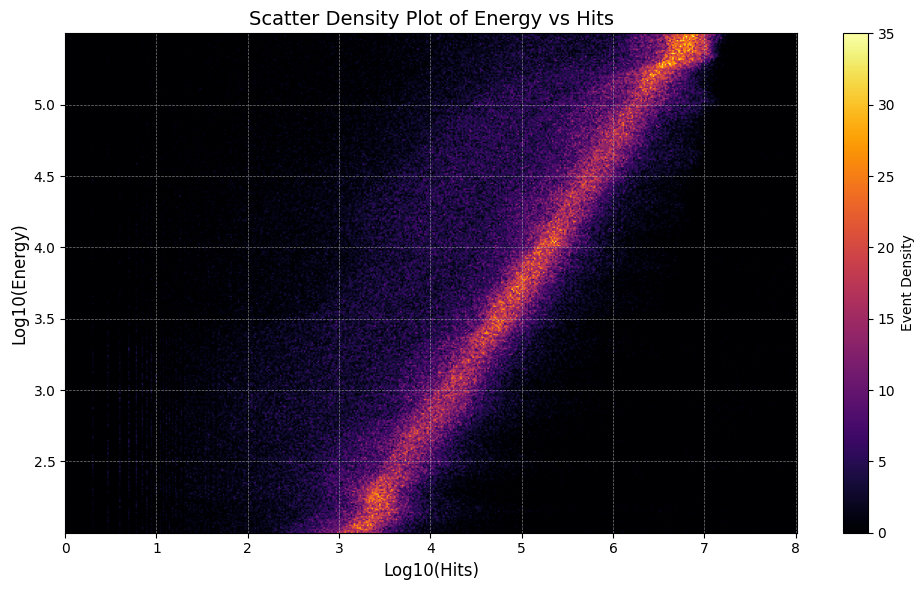

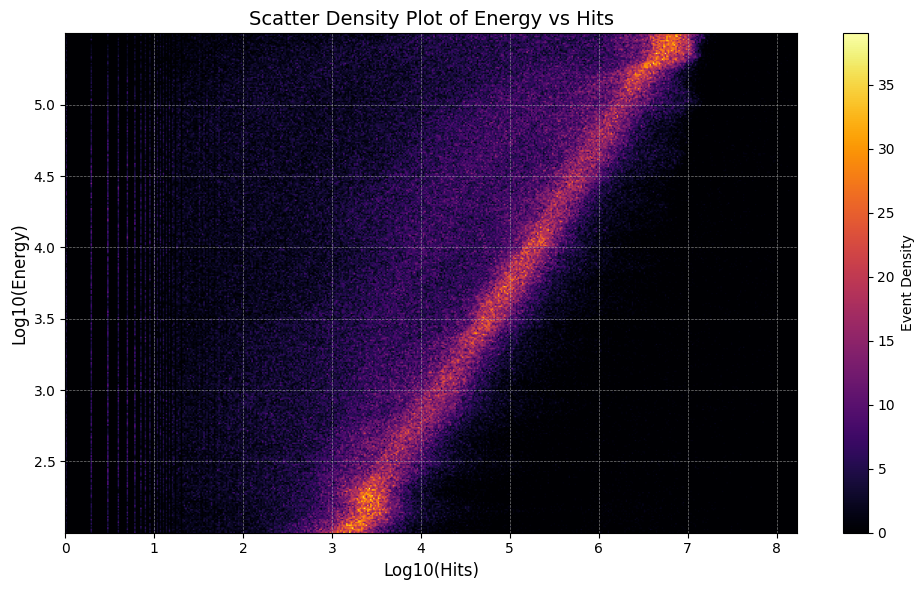

In [59]:
Track=np.load('/viper/u1/arego/Project/Thesis/EvH_LT1.npy')
plot_energy_hits(Track)
RDT=np.load('/viper/u1/arego/Project/Thesis/EvHRT.npy')
plot_energy_hits(RDT)
Cascades=np.load('/viper/u1/arego/Project/Thesis/EvH_LC.npy')
plot_energy_hits(Cascades)
c=np.vstack((Track,Cascades))
plot_energy_hits(c)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
EL=np.load('/viper/u1/arego/Project/Thesis/ELHitCount.npy')

In [35]:
Bio=np.load('/viper/u1/arego/Project/Thesis/BioHitCount.npy')

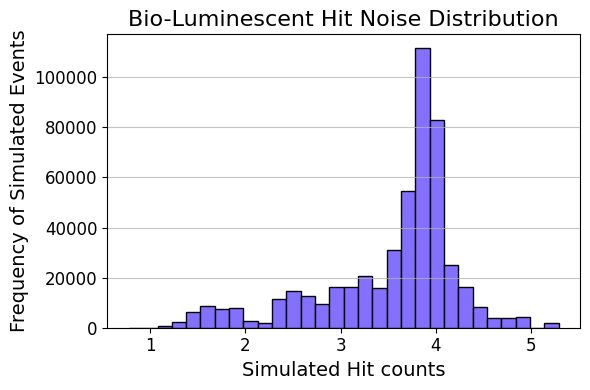

In [80]:
plt.figure(figsize=(6, 4))  # Set figure size
plt.hist(np.log10(Bio[:, 1]), bins=30, color='#8470FF', edgecolor='black')  # Adjust number of bins and colors
plt.title('Bio-Luminescent Hit Noise Distribution', fontsize=16)  # Title
plt.xlabel('Simulated Hit Counts', fontsize=14)  # X-axis label
plt.ylabel('Frequency of Simulated Events', fontsize=14)  # Y-axis label
plt.grid(axis='y', alpha=0.75)  # Add grid lines for better readability
plt.xticks(fontsize=12)  # X-axis tick labels
plt.yticks(fontsize=12)  # Y-axis tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

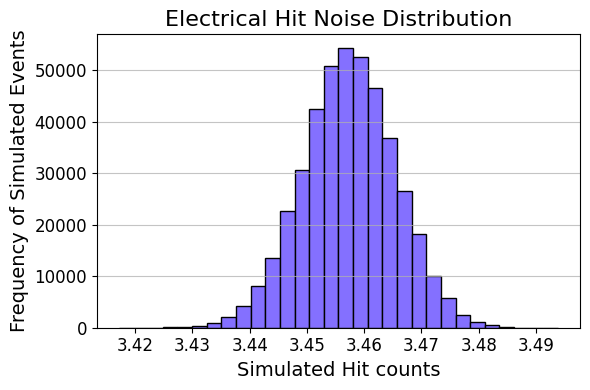

In [81]:
plt.figure(figsize=(6, 4))  # Set figure size
plt.hist(np.log10(EL[:, 1]), bins=30, color='#8470FF', edgecolor='black')  # Adjust number of bins and colors
plt.title('Electrical Noise Hit Distribution', fontsize=16)  # Title
plt.xlabel('Simulated Hit Counts', fontsize=14)  # X-axis label
plt.ylabel('Frequency of Simulated Events', fontsize=14)  # Y-axis label
plt.grid(axis='y', alpha=0.75)  # Add grid lines for better readability
plt.xticks(fontsize=12)  # X-axis tick labels
plt.yticks(fontsize=12)  # Y-axis tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

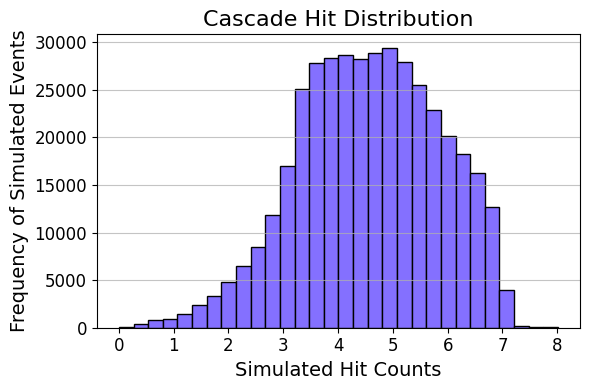

In [66]:
plt.figure(figsize=(6, 4))  # Set figure size
plt.hist(np.log10(Cascades[:,1]), bins=30, color='#8470FF', edgecolor='black')  # Adjust number of bins and colors
plt.title('Cascade Hit Distribution', fontsize=16)  # Title
plt.xlabel('Simulated Hit Counts', fontsize=14)  # X-axis label
plt.ylabel('Frequency of Simulated Events', fontsize=14)  # Y-axis label
plt.grid(axis='y', alpha=0.75)  # Add grid lines for better readability
plt.xticks(fontsize=12)  # X-axis tick labels
plt.yticks(fontsize=12)  # Y-axis tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

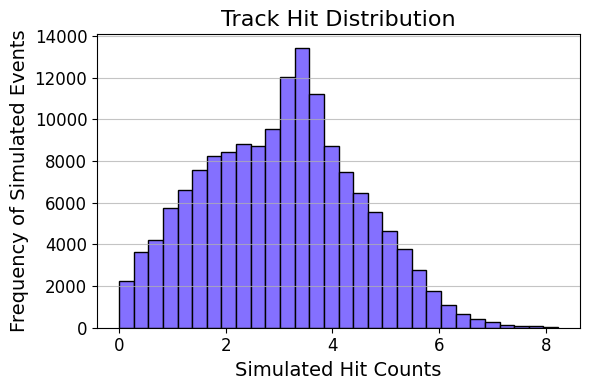

In [65]:
plt.figure(figsize=(6, 4))  # Set figure size
plt.hist(np.log10(Track[:,1]), bins=30, color='#8470FF', edgecolor='black')  # Adjust number of bins and colors
plt.title('Track Hit Distribution', fontsize=16)  # Title
plt.xlabel('Simulated Hit Counts', fontsize=14)  # X-axis label
plt.ylabel('Frequency of Simulated Events', fontsize=14)  # Y-axis label
plt.grid(axis='y', alpha=0.75)  # Add grid lines for better readability
plt.xticks(fontsize=12)  # X-axis tick labels
plt.yticks(fontsize=12)  # Y-axis tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

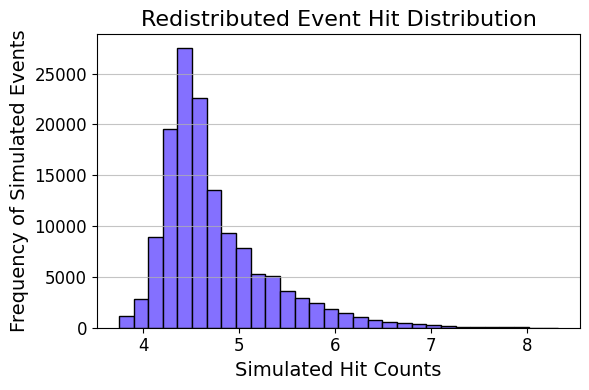

In [64]:
plt.figure(figsize=(6, 4))  # Set figure size
plt.hist(np.log10(RDT[:,1]), bins=30, color='#8470FF', edgecolor='black')  # Adjust number of bins and colors
plt.title('Redistributed Event Hit Distribution', fontsize=16)  # Title
plt.xlabel('Simulated Hit Counts', fontsize=14)  # X-axis label
plt.ylabel('Frequency of Simulated Events', fontsize=14)  # Y-axis label
plt.grid(axis='y', alpha=0.75)  # Add grid lines for better readability
plt.xticks(fontsize=12)  # X-axis tick labels
plt.yticks(fontsize=12)  # Y-axis tick labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [67]:
[file for file in os.listdir('/viper/u1/arego/Project/Thesis/') if '.npy' in file]

['ELHitCount.npy', 'BioHitCount.npy', 'EvH_LC.npy', 'EvHRT.npy', 'EvH_LT1.npy']

In [ ]:
import os
import shutil
import re

def get_normalized_name(name):
    """Normalize directory names by sorting the numbers (e.g., 3_2 -> 2_3)."""
    numbers = sorted(name.split("_"), key=int)
    return "_".join(numbers)

def merge_directories(parent_dir):
    """Merge directories with the same numeric components."""
    subdirs = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]
    print(f"Found subdirectories: {subdirs}")
    
    # Filter directories that match the pattern (numbers separated by underscores)
    pattern = re.compile(r'^\d+(?:_\d+)*$')
    grouped_dirs = {}
    
    for subdir in subdirs:
        if pattern.match(subdir):
            norm_name = get_normalized_name(subdir)
            print(f"Normalizing {subdir} -> {norm_name}")
            
            if norm_name not in grouped_dirs:
                grouped_dirs[norm_name] = []
            grouped_dirs[norm_name].append(subdir)
    
    print("Grouped directories:", grouped_dirs)
    
    # Process and merge directories
    for norm_name, dirs in grouped_dirs.items():
        if len(dirs) > 1:
            merged_path = os.path.join(parent_dir, norm_name)
            if norm_name in dirs:
                dirs.remove(norm_name)  # Prevent moving into itself
            print(f"Creating/Using directory: {merged_path}")
            # os.makedirs(merged_path, exist_ok=True)  # Commented out to prevent accidental creation
            
            for dir_name in dirs:
                src_path = os.path.join(parent_dir, dir_name)
                print(f"Merging {dir_name} into {norm_name}")
                
                for item in os.listdir(src_path):
                    src_item = os.path.join(src_path, item)
                    dst_item = os.path.join(merged_path, item)
                    
                    if os.path.exists(dst_item):
                        print(f"Skipping existing file: {dst_item}")
                    else:
                        print(f"Would move {src_item} -> {dst_item}")
                        shutil.move(src_item, dst_item)
                
                print(f"Would remove empty directory: {src_path}")
                os.rmdir(src_path)  # Commented out to prevent accidental deletion

if __name__ == "__main__":
    parent_directory = "/viper/u1/arego/Project/Thesis/plot/TD/"  # Change this to the actual directory
    print(f"Starting merge process in: {parent_directory}")
    merge_directories(parent_directory)
    print("Merge process complete.")


Starting merge process in: /viper/u1/arego/Project/Thesis/plot/TD/
Found subdirectories: ['21', '2', '2_20', '2_21', 'R1T4K', '20_21', '20', '2_20_21']
Normalizing 21 -> 21
Normalizing 2 -> 2
Normalizing 2_20 -> 2_20
Normalizing 2_21 -> 2_21
Normalizing 20_21 -> 20_21
Normalizing 20 -> 20
Normalizing 2_20_21 -> 2_20_21
Grouped directories: {'21': ['21'], '2': ['2'], '2_20': ['2_20'], '2_21': ['2_21'], '20_21': ['20_21'], '20': ['20'], '2_20_21': ['2_20_21']}
Merge process complete.


array([ 100.00121524, 5571.        ])

In [68]:
import dask.dataframe as dd

# Specify the directory containing Parquet files
directory_path = '/viper/u1/arego/Project/Thesis/plot/TD/2/'

# Read all Parquet files lazily
ddf = dd.read_parquet(directory_path)

# To trigger computation, you can convert it to a pandas DataFrame or perform operations
# df = ddf.compute()  # Uncomment to convert to a pandas DataFrame

# Example operation
# print(ddf.head())  # View the first few rows lazily


In [69]:
ddf["Mod"]

record_id  Mod Count CL: 0  Mod Hit Count CL: 0  Mod Count CL: 1  \
0          0               28                 2216               23   
1          1              285                40693              235   
2          3             3140               732418             2655   
3          4               24                 2206               22   
4          8               55                 1437               46   

   Mod Hit Count CL: 1  Mod Count CL: 2  Mod Hit Count CL: 2  Mod Count CL: 3  \
0                 2211               15                 2181               13   
1                40628              202                40530              177   
2               731898             2306               730916             1993   
3                 2204               14                 2182               12   
4                 1427               39                 1411               33   

   Mod Hit Count CL: 3  Mod Count CL: 4  ...  Mod Hit Count CL: 11  \
0                 2175               10  ...                     0   
1                40443              159  ...                   878   
2               729405             1727  ...                 14505   
3                 2176               10  ...                     0   
4                 1393               28  ...                     0   

   Mod Count CL: 12  Mod Hit Count CL: 12  Mod Count CL: 13  \
0                 0                     0                 0   
1                 0                     0                 0   
2                12                  2140                 6   
3                 0                     0                 0   
4                 0                     0                 0   

   Mod Hit Count CL: 13  Mod Count CL: 14  Mod Hit Count CL: 14  \
0                     0                 0                     0   
1                     0                 0                     0   
2                  1538                 2                   364   
3                     0                 0                     0   
4                     0                 0                     0   

   Mod Count CL: 15  Mod Hit Count CL: 15         energy  
0                 0                     0    6185.512465  
1                 0                     0  212140.182016  
2                 0                     0  209061.020005  
3                 0                     0    1234.269741  
4                 0                     0    8386.445072  

[5 rows x 34 columns]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mpl_scatter_density
import pandas as pd
import imageio

# Define colormap
cmap = plt.cm.inferno  

def sanitize_filename(name):
    """Replace problematic characters in filenames."""
    return name.replace(" ", "_").replace("_", "_")

def plot_energy_hits(hit, energy, col, filename, xlim=None, ylim=None, vmin=None, vmax=None):
    """Generates and saves a scatter density plot."""
    
    valid_indices = (energy > 0) & (hit > 0)
    hit = hit[valid_indices]
    energy = energy[valid_indices]

    if hit.shape[0] == 0 or energy.shape[0] == 0:
        return None  # Skip empty plots

    x = np.log10(hit)
    y = np.log10(energy)

    fig = plt.figure(figsize=(10, 6))  # Fixed size
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

    # Create density plot with varying color scale
    density = ax.scatter_density(x, y, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(density, label='Event Density')

    # Set axis limits to maintain consistency from the first column
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_xlabel("Log10(Hits)", fontsize=12)
    ax.set_ylabel("Log10(Energy)", fontsize=12)
    ax.set_title(f"Scatter Density Plot of {col}", fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(filename)  # Save the frame
    plt.close(fig)  # Free memory

# Directory to store images & GIFs
output_dir = "/raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1"
os.makedirs(output_dir, exist_ok=True)

for file in files:
    df = pd.read_parquet(file)
    print(f"Processing: {file}")

    image_files = []  # Reset for each file

    # Get limits from the first column
    first_col = cols[0]
    valid_indices = (df[first_col] > 0) & (df["energy"] > 0)
    initial_hits = df[first_col][valid_indices]
    initial_energy = df["energy"][valid_indices]

    if initial_hits.shape[0] > 0 and initial_energy.shape[0] > 0:
        initial_x = np.log10(initial_hits)
        initial_y = np.log10(initial_energy)

        # Set limits based on the first column
        xlim = (initial_x.min(), initial_x.max())
        ylim = (initial_y.min(), initial_y.max())

        # Use the last column for color scale
        last_col = cols[-1]
        last_col_data = df[last_col][valid_indices]
        
        # Calculate vmin and vmax based on the last column
        vmin = np.log10(last_col_data.min()) if last_col_data.min() > 0 else None
        vmax = np.log10(last_col_data.max())

        for col in cols:
            safe_col = sanitize_filename(col)
            img_path = os.path.join(output_dir, f"{os.path.basename(file)}_{safe_col}.png")
            
            plot_energy_hits(df[col], df["energy"], col, img_path, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
            
            if os.path.exists(img_path):  # Ensure file was created
                image_files.append(img_path)

        # ✅ Create a GIF for this file (only if images exist)
        if image_files:
            gif_path = os.path.join(output_dir, f"{os.path.basename(file)}.gif")
            imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)
            print(f"GIF saved: {gif_path}")
        else:
            print(f"No images generated for {file}, skipping GIF.")
    else:
        print(f"No valid data in the first column for {file}.")


In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mpl_scatter_density
import pandas as pd
import imageio

path='/viper/u1/arego/Project/Thesis/plot/TD/'
files=[os.path.join(path,file) for file in os.listdir(path) if "parquet" in file]

# Define colormap
cmap = plt.cm.inferno  

def sanitize_filename(name):
    """Replace problematic characters in filenames."""
    return name.replace(" ", "_").replace("_", "_")

def plot_energy_hits(hit, energy, col, filename, xlim=None, ylim=None, vmin=None, vmax=None):
    """Generates and saves a scatter density plot."""
    
    valid_indices = (energy > 0) & (hit > 0)
    hit = hit[valid_indices]
    energy = energy[valid_indices]

    if hit.shape[0] == 0 or energy.shape[0] == 0:
        return None  # Skip empty plots

    x = np.log10(hit)
    y = np.log10(energy)

    fig = plt.figure(figsize=(10, 6))  # Fixed size
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

    # Create density plot with varying color scale
    density = ax.scatter_density(x, y, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(density, label='Event Density')

    # Set axis limits to maintain consistency from the first column
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.set_xlabel("Log10(Hits)", fontsize=12)
    ax.set_ylabel("Log10(Energy)", fontsize=12)
    ax.set_title(f"Scatter Density Plot of {col}", fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(filename)  # Save the frame
    plt.close(fig)  # Free memory

# Directory to store images & GIFs
output_dir = "/raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1"
os.makedirs(output_dir, exist_ok=True)

for file in files:
    df = pd.read_parquet(file)
    print(f"Processing: {file}")

    image_files = []  # Reset for each file

    # Get limits from the first column
    cols=[col for col in df.columns if "Hit" in col]
    first_col = cols[0]
    valid_indices = (df[first_col] > 0) & (df["energy"] > 0)
    initial_hits = df[first_col][valid_indices]
    initial_energy = df["energy"][valid_indices]

    if initial_hits.shape[0] > 0 and initial_energy.shape[0] > 0:
        initial_x = np.log10(initial_hits)
        initial_y = np.log10(initial_energy)

        # Set limits based on the first column
        xlim = (initial_x.min(), initial_x.max())
        ylim = (initial_y.min(), initial_y.max())

        # Use the last column for color scale
        last_col = cols[-1]
        last_col_data = df[last_col][valid_indices]
        
        # Calculate vmin and vmax based on the last column
        vmin = np.log10(last_col_data.min()) if last_col_data.min() > 0 else None
        vmax = np.log10(last_col_data.max())

        for col in cols:
            safe_col = sanitize_filename(col)
            img_path = os.path.join(output_dir, f"{os.path.basename(file)}_{safe_col}.png")
            
            plot_energy_hits(df[col], df["energy"], col, img_path, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
            
            if os.path.exists(img_path):  # Ensure file was created
                image_files.append(img_path)

        # ✅ Create a GIF for this file (only if images exist)
        if image_files:
            gif_path = os.path.join(output_dir, f"{os.path.basename(file)}.gif")
            imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)
            print(f"GIF saved: {gif_path}")
        else:
            print(f"No images generated for {file}, skipping GIF.")
    else:
        print(f"No valid data in the first column for {file}.")

        

Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_21.parquet


/tmp/ipykernel_15734/3509494265.py:84: RuntimeWarning: divide by zero encountered in log10
  vmax = np.log10(last_col_data.max())
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/tmp/ipykernel_15734/3509494265.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)


GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_21.parquet.gif
Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_2.parquet


/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/tmp/ipykernel_15734/3509494265.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)


GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_2.parquet.gif
Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_2_20_21.parquet


/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/tmp/ipykernel_15734/3509494265.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)


GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_2_20_21.parquet.gif
Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_2_21.parquet


/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/tmp/ipykernel_15734/3509494265.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)


GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_2_21.parquet.gif
Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_2_20.parquet


/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/tmp/ipykernel_15734/3509494265.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)


GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_2_20.parquet.gif
Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_20_21.parquet


/tmp/ipykernel_15734/3509494265.py:84: RuntimeWarning: divide by zero encountered in log10
  vmax = np.log10(last_col_data.max())
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/tmp/ipykernel_15734/3509494265.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(gif_path, [imageio.imread(img) for img in image_files], duration=1)


GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_20_21.parquet.gif
Processing: /viper/u1/arego/Project/Thesis/plot/TD/Merged_20.parquet


/tmp/ipykernel_15734/3509494265.py:84: RuntimeWarning: divide by zero encountered in log10
  vmax = np.log10(last_col_data.max())
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/scatter_density_axes.py:48: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.set_xlim(np.min(x), np.max(x))
/raven/u/arego/olympus/lib/python3.10/site-packages/mpl_scatter_density/scatter_density_axes.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.set_ylim(np.min(y), np.max(y))
/tmp

GIF saved: /raven/u/arego/project/Stuff_For_Thesis/scatter_frames_1/Merged_20.parquet.gif
